# Association Rule Mining for Survivor

Authors: Derek Rogers


### Business Understanding:

The goal of this project is to analyze data from the TV show "Survivor" for multiple countries (US, Australia, South Africa, and New Zealand). The data used is collected by fans of the TV show trying to gain insights.  We import it from an R package called survivoR which contains various information about the contestants, including castaway details, vote history, immunity and reward challenge winners, jury votes, advantage details, and more. The purpose of this analysis is to gain insights and answer questions related to the Survivor game, particularly to identify attributes that may influence the order of elimination for players in a season. By understanding these attributes, we aim to predict the next contestant who is likely to be eliminated, potentially discovering patterns shared by contestants who make it further or even win the show. 

The code implements a leave-one-group-out cross-validation technique, which aligns with the Survivor format. Each iteration of the cross-validation loop represents a new stage of the show, where a group of contestants is considered for prediction while excluding the others who have already been eliminated. This simulation approach ensures that the predictions are based on the available pool of contestants, mimicking the progression of the actual show.

### Data Understanding:

The survivoR package contains a diverse collection of datasets representing different Survivor seasons from various countries. The data includes both numerical and categorical attributes, each providing unique information about the contestants and the game's progression. One of the challenges we faced was the data contained some attributes that had many missing values which we could not use in our model, however, sufficient attributes were functional for our model. It is essential to explore the data, understand its structure, and identify potential relationships between attributes.  Additionally, we must consider the temporal aspect of the show, where contestants are eliminated in stages, and already eliminated contestants should not influence the predictions for subsequent stages.


### Imports and Formatting

Copying over data formatting logic from SurvivorSim.py

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
import os

os.environ['OMP_NUM_THREADS'] = '5'

warnings.filterwarnings("ignore", category=DataConversionWarning)

# Get the current working directory
current_dir = os.getcwd()

# Get the path to the survivorData directory
data_dir = os.path.join(current_dir, '..', 'survivorData2')

# List of CSV file names
csv_files = [
    'advantage_movement.csv',
    'boot_mapping.csv',
    'castaways.csv',
    'castaway_details.csv',
    'challenge_description.csv',
    'challenge_results.csv',
    'confessionals.csv',
    'jury_votes.csv',
    'screen_time.csv',
    'season_palettes.csv',
    'season_summary.csv',
    'survivor_auction.csv',
    'tribe_colours.csv',
    'tribe_mapping.csv',
    'viewers.csv',
    'vote_history.csv'
]

# Create a dictionary to store the DataFrames
dataframes = {}

# Loop through each CSV file and read its data into a DataFrame
for csv_file in csv_files:
    # Specify the relative path to the CSV file
    file_path = os.path.join(data_dir, csv_file)
    
    # Read the data from the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Store the DataFrame in the dictionary
    dataframes[csv_file] = df
    
# Convert tribe_status column to category type
dataframes['tribe_colours.csv']['tribe_status'] = dataframes['tribe_colours.csv']['tribe_status'].astype('category')

# Convert result to a categorical variable
dataframes['castaways.csv']['result'] = pd.Categorical(dataframes['castaways.csv']['result'])
dataframes['castaways.csv']['result'] = dataframes['castaways.csv']['result'].cat.codes

# Merge challenge_results and castaway_details dataframes on castaway_id
castawayAll = pd.merge(dataframes['castaways.csv'], dataframes['castaway_details.csv'], on='castaway_id', how ="left")

# Male = 1, Female = 2, Non-binary = 3
castawayAll['genderNumber'] = np.where(castawayAll['gender'] == 'Male', 1,
                                     np.where(castawayAll['gender'] == 'Female', 2,
                                              np.where(castawayAll['gender'] == 'Non-binary', 3, 0)))

# Binary on if the person was the sole survivor
castawayAll['won'] = np.where(castawayAll['result'] == 'Sole Survivor', 1, 0)

castawayAll = castawayAll.dropna(subset=['age'])

# Read the challenge_results.csv file
challenge_results = dataframes['challenge_results.csv']

# Filter out the rows where challenge_type is "Immunity" and the result is "Won"
immunity_wins = challenge_results[(challenge_results['challenge_type'] == 'Immunity') & (challenge_results['result'] == 'Won')]

# Group by 'castaway_id' and count the number of immunity wins
immunity_counts = immunity_wins.groupby('castaway_id').size()

# Convert Series to DataFrame
immunity_counts_df = immunity_counts.reset_index(name='immunityWins')

# Set 'castaway_id' as the index for easier merging later
immunity_counts_df.set_index('castaway_id', inplace=True)

# Set 'castaway_id' as the index for 'castawayAll' dataframe for easier merging
castawayAll.set_index('castaway_id', inplace=True)

# Merge 'immunity_counts_df' into 'castawayAll'
castawayAll = castawayAll.merge(immunity_counts_df, how='left', left_index=True, right_index=True)

# Fill NaN values with 0 - assuming that contestants who didn't win any immunity challenges are not present in the immunity_counts_df DataFrame
castawayAll['immunityWins'].fillna(0, inplace=True)

# Split dataframe into a list of dataframes grouped by column name
def split_dataframe(df, column_name):
    groups = df.groupby(column_name)
    result = [group for _, group in groups]
    return result

# Call split_dataframe on column name "version_season"
season_split = split_dataframe(castawayAll, 'version_season')

# Give each contestant which order they were eliminated from the show
for df in season_split:
    df['orderOut'] = range(1, len(df) + 1)


Select features to analyze then normalize the scalers

In [40]:
# Select features for clustering
features = ['age', 'genderNumber', 'immunityWins']

data_clustering = castawayAll[features]

# Normalize the features for clustering
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_clustering)

# Cluster Analysis

### Comparison of K-means Clustering, Agglomerative Hierarchial Clustering, and DBSCAN Algorithms


To determine the best approach for predicting the order of elimination of contestants for each season, we have chosen to compare the performance of three different clustering algorithms: K-means Clustering, Agglomerative Hierarchical Clustering, and DBSCAN. 

1. **K-means Clustering:** Unsupervised machine learning algorithm which groups an unlabeled dataset into partitional clusters that are center-based and well-separated. Each cluster is associated with a cluster, or center point. 
2. **Agglomerative Hierarchical Clustering:** A bottom-up clustering algorithm that considers each dataset as a single cluster at the beginning and then starts combining the closest pair of clusters together producing a set of nested clusters organized as a hierarchical tree. This can be visualized using a dendogram. 
3. **DBSCAN (Density-based Spatial Clustering of Applications with Noise):** A density-based clustering algorithm that works on the assumption that clusters are dense regions in space separated by regions of lower density and can resist noise and handle clusters of different shapes and sizes. 

### Determining Optimal Clusters

The following evaluation metrics are used to assess the quality of clustering results: 
1.  **Silhouette Coefficient:** The silhouette score measures how well-separates the clusters are and quantifies the quality of clusters. It takes values between -1 and 1 with higher values indicating better-defined and well=separated clusters. The optimal number of clusters is determined based on the highest silhouette score, which indicates the best balance between well-defined clusters and minimal overlap between them. 
2. **Calinski-Harabasz Index:** Also known as the Variance Ratio Criterion, this internal evaluation metric is used for clustering quality. It computes the ratio of the between-cluster dispersion to the within-cluster dispersion. A higher index value indicates better-defined and more separated clusters. 
3. **Elbow Method:** Used only for K-Means, a process called the "elbow method" was also used which captures the WCSS (Within-Cluster Sum of Squares) values which represent the sum of squared distances between data points and their assigned cluster centroids, and it is a measure of how compact the clusters are.

For K-Means and Agglomerative Clustering, the optimal number of clusters found is 6.

### Optimal Clusters for K-means
 

In [41]:
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 11)  # try from 2 to 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    cluster_labels = kmeans.fit_predict(data_normalized)
    silhouette_avg = silhouette_score(data_normalized, cluster_labels)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_avg)

optimal_n_clusters_kmeans = range_n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters for K-means: ", optimal_n_clusters_kmeans)


Optimal number of clusters for K-means:  6


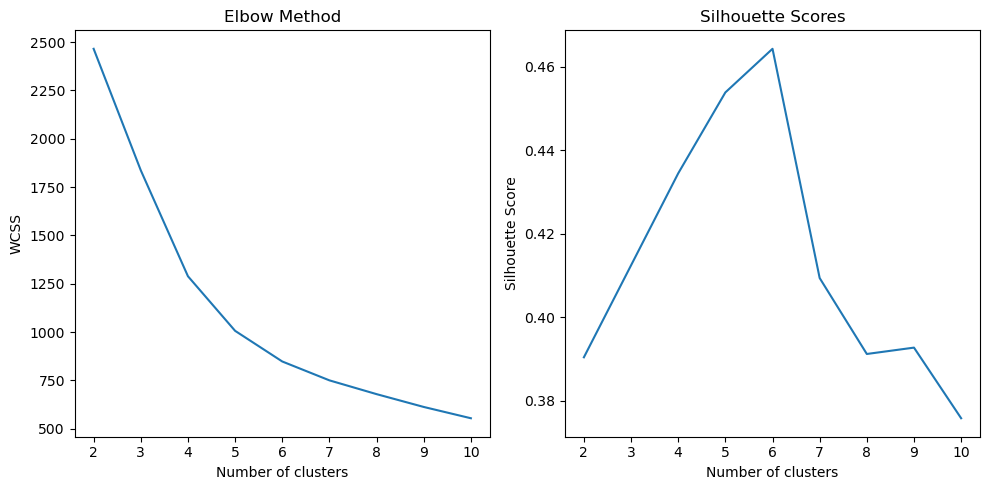

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [43]:
# fit the K-means model with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters_kmeans, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y_kmeans = kmeans.fit_predict(data_normalized)

### Optimal Clusters for Hierarchial Agglomerative Clustering

Optimal number of clusters for Agglomerative Clustering:  6


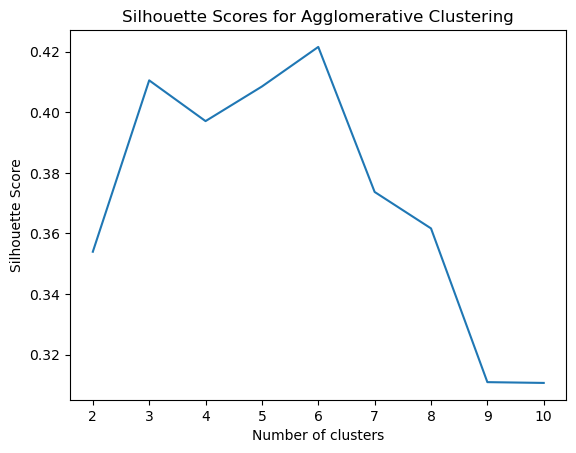

In [44]:
silhouette_scores_agg = []

for n_clusters in range_n_clusters:
    agglo = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglo.fit_predict(data_normalized)
    silhouette_avg = silhouette_score(data_normalized, cluster_labels)
    silhouette_scores_agg.append(silhouette_avg)

optimal_n_clusters_agglo = range_n_clusters[np.argmax(silhouette_scores_agg)]
print("Optimal number of clusters for Agglomerative Clustering: ", optimal_n_clusters_agglo)

# Plot the silhouette scores
plt.plot(range_n_clusters, silhouette_scores_agg)
plt.title('Silhouette Scores for Agglomerative Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Fit the model with the optimal number of clusters
agglo = AgglomerativeClustering(n_clusters=optimal_n_clusters_agglo)
pred_y_agglo = agglo.fit_predict(data_normalized)

In [45]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
pred_y_dbscan = dbscan.fit_predict(data_normalized)

print(pred_y_dbscan)

[0 1 0 ... 1 1 0]


In [46]:
# Compute Silhouette Coefficient for each clustering
silhouette_kmeans = metrics.silhouette_score(data_normalized, pred_y_kmeans)
silhouette_agglo = metrics.silhouette_score(data_normalized, pred_y_agglo)
silhouette_dbscan = metrics.silhouette_score(data_normalized, pred_y_dbscan)

print("Silhouette Coefficient for K-means: %0.3f" % silhouette_kmeans)
print("Silhouette Coefficient for Agglomerative Clustering: %0.3f" % silhouette_agglo)
print("Silhouette Coefficient for DBSCAN: %0.3f" % silhouette_dbscan)

# Compute Calinski-Harabasz Index for each clustering
calinski_kmeans = metrics.calinski_harabasz_score(data_normalized, pred_y_kmeans)
calinski_agglo = metrics.calinski_harabasz_score(data_normalized, pred_y_agglo)
calinski_dbscan = metrics.calinski_harabasz_score(data_normalized, pred_y_dbscan)

print("\nCalinski-Harabasz Index for K-means: %0.3f" % calinski_kmeans)
print("Calinski-Harabasz Index for Agglomerative Clustering: %0.3f" % calinski_agglo)
print("Calinski-Harabasz Index for DBSCAN: %0.3f" % calinski_dbscan)

Silhouette Coefficient for K-means: 0.464
Silhouette Coefficient for Agglomerative Clustering: 0.422
Silhouette Coefficient for DBSCAN: 0.344

Calinski-Harabasz Index for K-means: 833.400
Calinski-Harabasz Index for Agglomerative Clustering: 744.397
Calinski-Harabasz Index for DBSCAN: 224.284


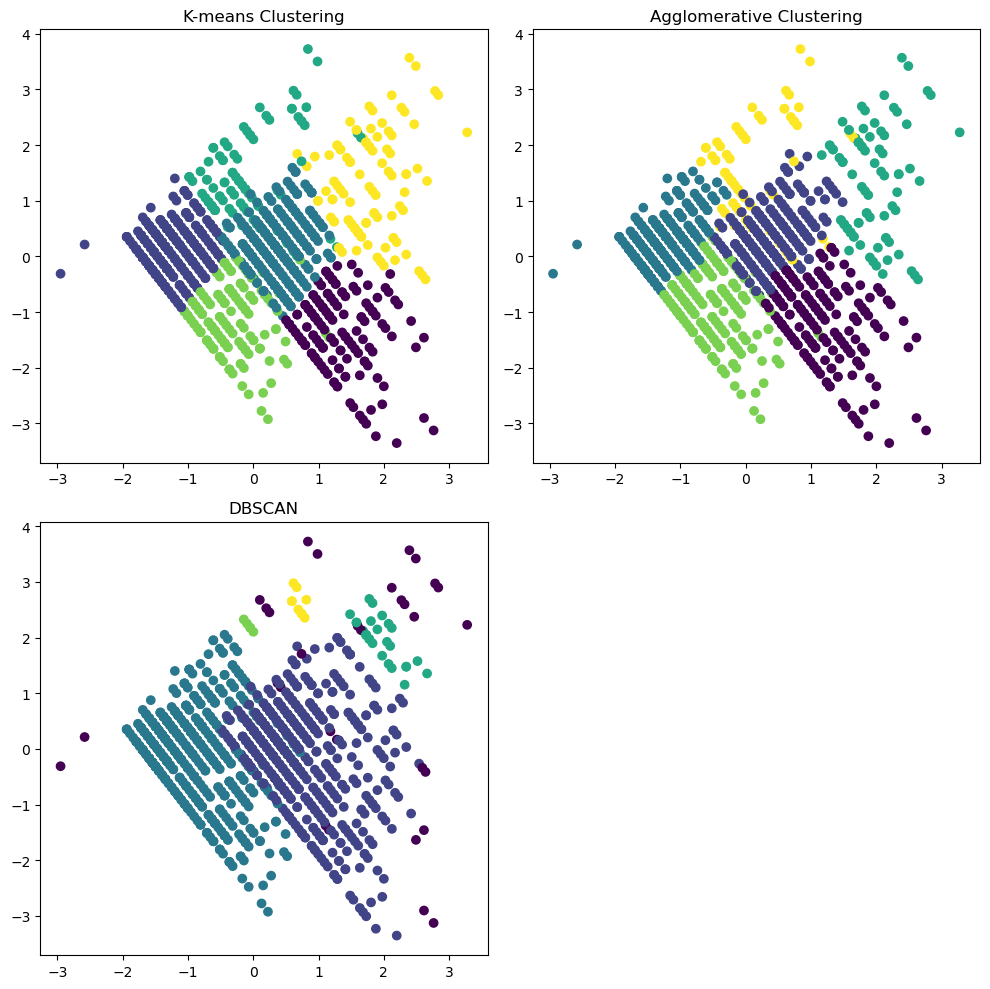

In [47]:
# Initialize PCA with 2 components
pca = PCA(n_components=2)

# Fit and transform the data
pca_result = pca.fit_transform(data_normalized)

# Create a scatter plot
plt.figure(figsize=(10,10))

# KMeans
plt.subplot(221)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pred_y_kmeans)
plt.title('K-means Clustering')

# Agglomerative Clustering
plt.subplot(222)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pred_y_agglo)
plt.title('Agglomerative Clustering')

# DBSCAN
plt.subplot(223)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=pred_y_dbscan)
plt.title('DBSCAN')

plt.tight_layout()
plt.show()

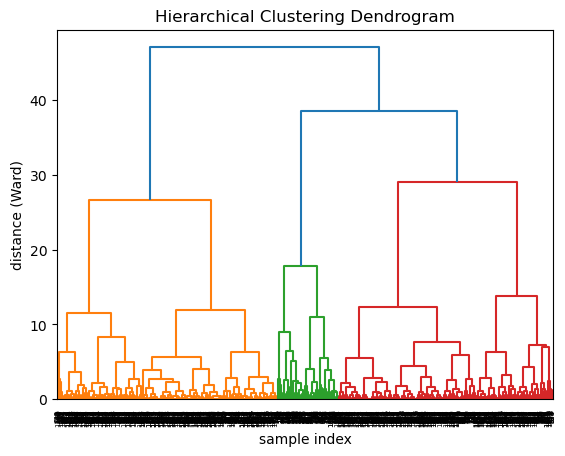

In [48]:
# Create a linkage matrix using ward linkage
Z = linkage(data_normalized, method='ward')

# Create a dendrogram
dendrogram(Z)

# Display the dendrogram
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance (Ward)')
plt.show()

# Deployment

### Evaluation of Performance and Utility

We were able to achieve our goal of creating a walk-forward cross-validation model to predict voting outcomes in the context of Survivor using up to date information before each vote. While our cluster analysis was unhelpful, we managed to develop complex models that could prove valueable if used in other applications.

The model results and cluster analysis validated our suspicion that the models don't perform well in their current form. Although designed to assess metrics across various models, the project's implementation does not facilitate real-time predictive insights, which inhibits its practicality. Small adjustments could allow the creation of predictions for new season data, but overall, the project requires further improvement in terms of code functionality and alignment with real-world applications.

### Usefulness to Interested Parties

This project could serve as a vital foundation for those interested in data-driven understandings of Survivor, particularly for predicting who will be voted off next. It provides a starting point that can be further refined to enhance Survivor predictions effectively.

### Deployment for Interested Parties

Currently, deployment is limited. For the model to be beneficial to organizations or individuals, it will require additional development. This could encompass integrating the model into a user-friendly interface, optimizing for real-time predictions, and adapting it to align with the specific interests and needs of potential users.

### Additional Data Collection

Enhancing the model with data on interpersonal relationships would be ideal but remains a challenging and potentially unfeasible task with existing datasets. Tracking tribes and understanding tribe dynamics throughout the season may provide valuable insights. For example, patterns could emerge showing that castaways who have been in the same tribe for an extended time are less likely to vote each other out.

### Model Update Frequency

The model would need updates to coincide with Survivor's voting schedule, as not all days feature a vote. Continuous monitoring and timely updates are critical to ensure ongoing accuracy and relevance in predictions. This highlights the necessity for a more streamlined process that can manage these updates efficiently, without extensive manual oversight.

### Conclusion

The project showcases promising methodologies and concepts but encounters barriers in practical application and real-world relevance. To transition from a research and development stage to a functional tool for interested parties, further work is essential. Focus areas include deployment, data enrichment, and enhancing real-time adaptability. By addressing these challenges, the project has the potential to become a valuable resource for those looking to employ data analytics to unravel and predict the multifaceted dynamics of Survivor.